In [1]:
%cd Documents/Biomedical Computer Vision

[WinError 3] Impossibile trovare il percorso specificato: 'Documents/Biomedical Computer Vision'
c:\Users\Pier\Documents\BioCV


In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import f1_score
from torch import nn
import matplotlib.pyplot as plt


In [3]:
import src.preprocessing_main as pre

''' This function expects the Train_Sets folder in the same directory as the script.'''
pre.preprocess()

pre.removeSpir()



Dataset integrity check:


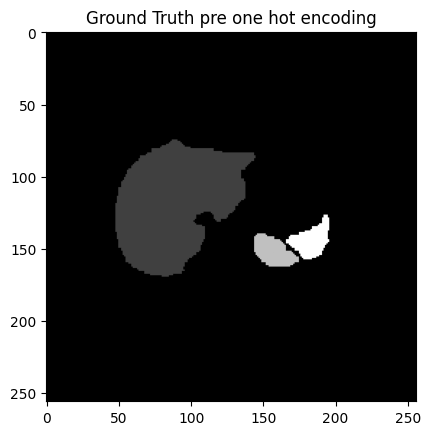

In [4]:
# check dataset integrity

dataset = np.load("mr_no_spir.npz", allow_pickle=True)
dataset = dataset['arr_0'].item()

print("Dataset integrity check:")
plt.imshow(dataset['1']['T1DUAL']['Ground'][43], cmap='gray')
plt.title('Ground Truth pre one hot encoding')
plt.show()



In [5]:
from src.dataset_handler import train_val_split, BioCVDataset
from src.UNet_model import createModel, summary
from src.training_utils import train_model, ToTensor, predict
import os

#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


# check device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0001
BATCH_SIZE = 8
N_EPOCHS = 100

IMG_SIZE = 32
N_CLASSES = 5
TEST_PHASE = True
RESUME_TRAINING_FROM_MODEL = False
RESUME_TRAINING_FROM_CHECKPOINT = False

print(DEVICE)

# Original Dataset
#dataset = np.load("mr.npz", allow_pickle=True)
#dataset = dataset['arr_0'].item()

# No SPIR Dataset
dataset = np.load("mr_no_spir.npz", allow_pickle=True)
dataset = dataset['arr_0'].item()

def calculate_class_weights(trainLoader) -> torch.Tensor: 
    ''' Calculates the class weights for the dataset. The weights are calculated as the inverse of the class frequency in the dataset. 
    This is required to balance the classes in the dataset, since the classes are unbalanced with the background class being the most frequent one.'''
    class_counts = torch.zeros(5)  
    
    for sample in trainLoader:
        masks = sample['mask']
        class_counts += torch.bincount(masks.view(-1).long(), minlength=5)

    total_samples = class_counts.sum()
    class_weights = total_samples / (5 * class_counts)

    return class_weights


def main():
    torch.manual_seed(RANDOM_SEED)
    output_classes = 5

    # Splitting the dataset into training and validation sets
    train_data, val_data, test_data = train_val_split(dataset, validation_size=0.15, pedantic=False, noSpir=True) 

    # Check lengths
    # assert len(dataset) > 0, "Dataset length is not greater than 0"
    # assert len(train_data) > len(val_data), "Train dataset length is shorter than validation dataset length"
    
    # Check types and non-emptiness
    # first_patient_id = '1'
    # assert isinstance(train_data[first_patient_id], dict), "Train dataset first patient is not a dictionary"
    # assert bool(train_data[first_patient_id]), "Train dataset first patient dictionary is empty"

    # first_category = 'T1DUAL'
    # assert isinstance(train_data[first_patient_id][first_category], dict), "Train dataset first patient first category is not a dictionary"
    # assert bool(train_data[first_patient_id][first_category]), "Train dataset first patient first category dictionary is empty"

    # first_phase = 'InPhase'
    # assert isinstance(train_data[first_patient_id][first_category][first_phase], np.ndarray), "Train dataset first patient first category first phase is not a numpy array"
    # assert train_data[first_patient_id][first_category][first_phase].shape == (50, 256, 256), "Train dataset first patient first category first phase shape is not as expected"

    transformed_dataset_train = BioCVDataset(train_data, output_classes=output_classes, transform=transforms.Compose([ToTensor()]), noSpir=True)
    transformed_dataset_val = BioCVDataset(val_data, output_classes=output_classes, transform=transforms.Compose([ToTensor()]), noSpir=True)
    transformed_dataset_test = BioCVDataset(test_data, output_classes=output_classes, transform=transforms.Compose([ToTensor()]), noSpir=True)
    trainLoader = DataLoader(transformed_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
        
    class_weights = calculate_class_weights(trainLoader)

    class_weights[0] = class_weights[0] / 7

    print('Class weights: ', class_weights)

    validationLoader = DataLoader(transformed_dataset_val, batch_size=BATCH_SIZE, shuffle=True)
    testLoader = DataLoader(transformed_dataset_test, batch_size=BATCH_SIZE, shuffle=True)

    epochs_training = N_EPOCHS

    if TEST_PHASE:
        print('Testing phase')
        my_model_state = torch.load('results/models/UNet_1_4_2.pt')
        my_model = createModel(output_channels=output_classes)
        my_model.load_state_dict(my_model_state['best_model_wts'])
        accuracy, confusion_matrix = predict(my_model, testLoader, output_classes, class_weights)
        print('Done')
        return None

    elif RESUME_TRAINING_FROM_MODEL:
        my_model_state = torch.load('results/models/UNet_final.pt')
        my_model = createModel(output_channels=output_classes)
        my_model.load_state_dict(my_model_state['best_model_wts'])
        print('Resuming training from epoch ', my_model_state['epoch'])
        epochs_training = 30 #TODO modificare
        # Decomment to continue for more epochs
        #epochs_training = epochs_training + my_model_state['epoch']

    elif RESUME_TRAINING_FROM_CHECKPOINT:
        checkpoint = torch.load('training/checkpoint.pt')
        my_model = createModel(output_channels=output_classes)
        my_model.load_state_dict(checkpoint['best_model_wts'])
        num_epochs_old = checkpoint['epoch']
        max_epoch = num_epochs_old + 30
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))	
        optimizer = torch.optim.Adam(my_model.parameters(), lr=LEARNING_RATE)
        #criterion = None #TODO add criterion choice
        metrics = {'f1_score': f1_score}
        bpath = 'training'
        my_model_trained=train_model(my_model, criterion, trainLoader, validationLoader, optimizer, metrics, bpath, num_classes=N_CLASSES, num_epochs=max_epoch, resume=True, resume_path='training/checkpoint.pt')
        torch.save(my_model_trained.state_dict(), 'trained_UNet.pth')
        return None


    else:    
        my_model = createModel(output_channels=output_classes)
        print('New training session')  

    criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))	
    optimizer = torch.optim.Adam(my_model.parameters(), lr=LEARNING_RATE)
    #criterion = None #TODO add criterion choice
    metrics = {'f1_score': f1_score}
    bpath = 'training'

        
    my_model_trained=train_model(my_model, criterion, trainLoader, validationLoader, optimizer, metrics, bpath, num_classes=N_CLASSES, num_epochs=epochs_training, resume=False, resume_path=None, class_weights=class_weights)
    

    # Getting first batch of the training data to run the model and see its performance
    for i_batch, sample_batched in enumerate(trainLoader):
        print(i_batch, sample_batched['image'].size(),
          sample_batched['mask'].size())
        break
    
    # Once the model is trained, we can save it
    torch.save(my_model_trained.state_dict(), 'trained_UNet.pth')




cuda:0


In [6]:
main()


Class weights:  tensor([2.9902e-02, 6.2474e+00, 5.9846e+01, 5.5515e+01, 3.6129e+01])
Testing phase


100%|██████████| 25/25 [01:24<00:00,  3.39s/it]


Accuracy: 0.5193349687423723
accuracy per class:
Class 0: 0.8848633002529676
Class 1: 0.993390452876377
Class 2: 0.1087151841868823
Class 3: 0.5956331877729257
Class 4: 1.0
Confusion Matrix:
          0       1      2       3       4
0  11156805  451199  91439  121844  519241
1     11954  529501   1131       0       0
2     14602    6835  39823       0       0
3      5542       0      0   51408     848
4      4435       0      0       0  100593
Done


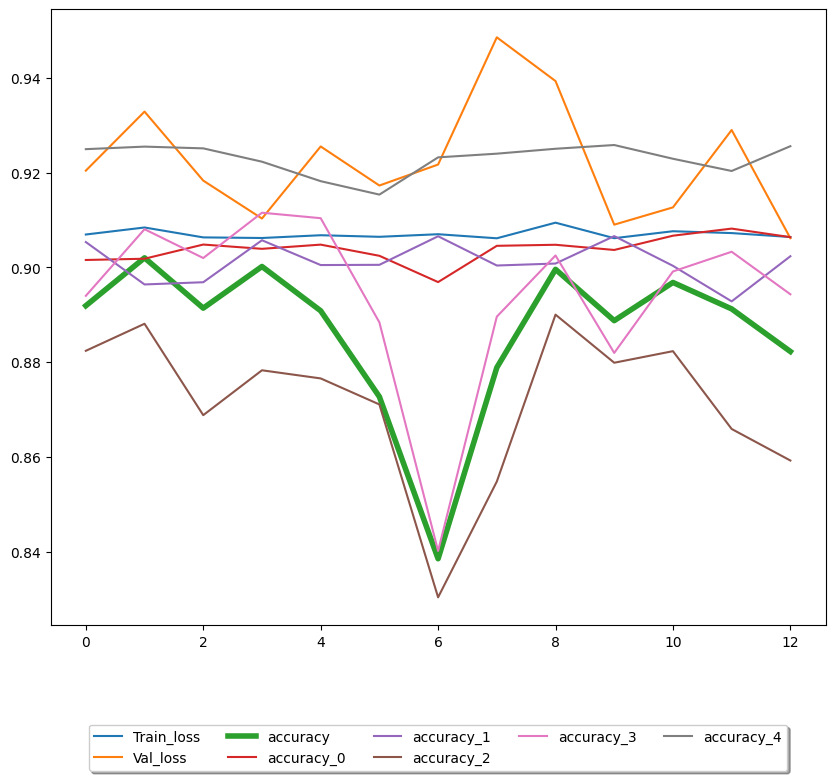

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Specify the path to your CSV file
csv_file_path = 'training/log.csv'

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_file_path, delimiter=';')
rows = len(df)

# Display the DataFrame
x_values = range(rows)

fig, ax = plt.subplots(figsize=(10, 10))


for key in df.columns:
    if key != 'epoch':
        if key in ['Train_loss', 'Val_loss', 'accuracy'] + ['accuracy_' + str(i) for i in range(5)]:
            if key == 'accuracy':
                # Highlight the 'accuracy' column
                ax.plot(x_values, df[key], label=key, linewidth=4)
            else:
                ax.plot(x_values, df[key], label=key)


# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                    box.width, box.height * 0.8])

# Put a legend below the current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)

# Display the plot
plt.show()
